In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import cv2
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
base_dir = '/kaggle/input/gtsrb-german-traffic-sign/'

# Load the CSV file containing the file paths and labels
labels_file = os.path.join(base_dir, 'Train.csv')
labels_df = pd.read_csv(labels_file)

data = []
labels = []

# Loop through each entry in the CSV file
for index, row in labels_df.iterrows():
    # Get the file path and label
    img_path = os.path.join(base_dir, row['Path'])  # Combine the base directory and the image file path
    label = row['ClassId']  # Get the label
    
    img = Image.open(img_path)
    img = img.resize((100, 100))  # Resize the image if needed
    img_array = np.array(img)  # Convert the image to a numpy array
        
    # Append image data and label to the respective lists
    data.append(img_array)
    labels.append(label)

In [3]:
data=np.array(data)
labels=np.array(labels)

In [4]:
data.shape,labels.shape

((39209, 100, 100, 3), (39209,))

In [5]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }

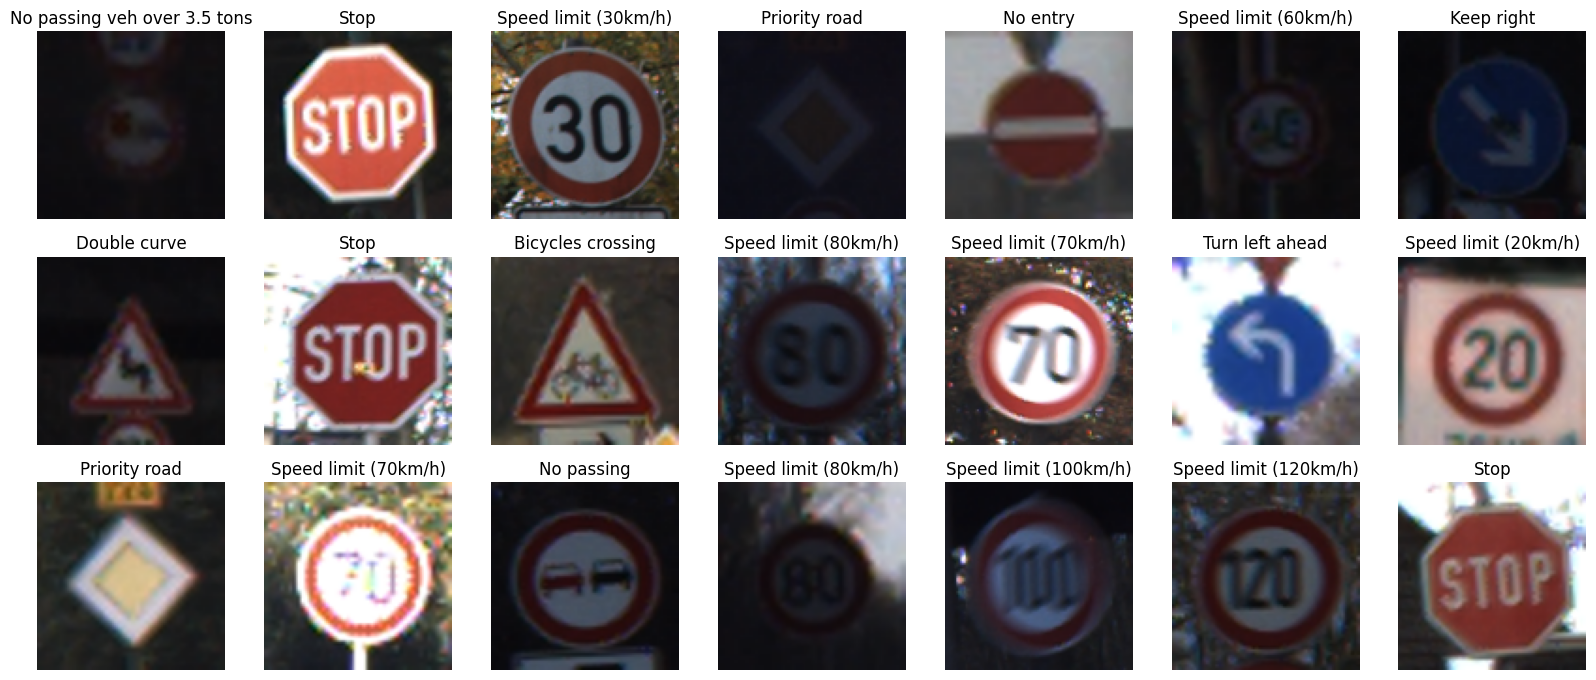

In [6]:
plt.figure(figsize=(20,20))
n=0
for i in range(21):
    l=np.random.randint(0,data.shape[0])
    plt.subplot(7,7,i+1)
    plt.imshow(data[l])
    plt.axis('off')
    plt.title(classes[labels[l]])
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, Y_train, Y_test= train_test_split(data, labels, test_size=0.2, random_state=42)


In [8]:
x_train=x_train.astype('float32')/255
x_test=x_test.astype('float32')/255

y_train=to_categorical(Y_train,43)
y_test=to_categorical(Y_test,43)

## Data Augmentation

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
# Define the data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=15,  # Mild rotations
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,    # Reduced shear range
    zoom_range=0.1,     # Mild zoom
    horizontal_flip=True,  # Random horizontal flips
    vertical_flip=False,
    fill_mode='nearest'
)

datagen.fit(x_train)

In [10]:
x_train.shape[0:]

(31367, 100, 100, 3)

## Built the Model

In [11]:
model=Sequential()
model.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu', input_shape=x_train.shape[1:]))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.5))

model.add(Conv2D(filters=128, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.5))



model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(43, activation='softmax'))

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 44, 44, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,145,323 (31.07 MB)

 Trainable params: 8,145,323 (31.07 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint('model.h5.keras', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
model.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_test, y_test), callbacks=[early_stop,checkpoint])

Epoch 1/30


I0000 00:00:1726660544.222175      73 service.cc:145] XLA service 0x7e8abc006b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726660544.222232      73 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726660544.222237      73 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  6/981 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.0301 - loss: 4.0426

I0000 00:00:1726660550.310923      73 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


981/981 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.4728 - loss: 1.9435 - val_accuracy: 0.9332 - val_loss: 0.2477
Epoch 2/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.9152 - loss: 0.2830 - val_accuracy: 0.9689 - val_loss: 0.1117
Epoch 3/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.9501 - loss: 0.1663 - val_accuracy: 0.9703 - val_loss: 0.1257
Epoch 4/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.9641 - loss: 0.1176 - val_accuracy: 0.9756 - val_loss: 0.0854
Epoch 5/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9706 - loss: 0.0970 - val_accuracy: 0.9853 - val_loss: 0.0577
Epoch 6/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.9726 - loss: 0.0886 - val_accuracy: 0.9834 - val_loss: 0.0598
Epoch 7/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.9771 - loss: 0.0757 - val_accuracy: 0.9782 - val_loss: 0.0751
Epoch 8/30
981/981 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - accuracy: 0.9768 - loss: 0.0763 - val_accurac

In [14]:
model.evaluate(x_test, y_test)

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9919 - loss: 0.0284


[0.033532578498125076, 0.9915837645530701]

In [15]:
from sklearn.metrics import classification_report
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred))

246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        44
           1       1.00      0.99      0.99       474
           2       0.99      1.00      0.99       452
           3       0.99      0.97      0.98       295
           4       1.00      1.00      1.00       420
           5       0.97      0.96      0.97       332
           6       1.00      1.00      1.00        82
           7       0.96      0.99      0.98       276
           8       0.99      0.97      0.98       283
           9       1.00      1.00      1.00       304
          10       1.00      1.00      1.00       349
          11       0.98      1.00      0.99       242
          12       1.00      1.00      1.00       454
          13       1.00      1.00      1.00       441
          14       1.00      1.00      1.00       167
          15       1.00      1.00      1.00       127
          16       1.00      1.00      1

## Evaluation Test

In [16]:
prediction =np.argmax(model.predict(x_test),axis=1)

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


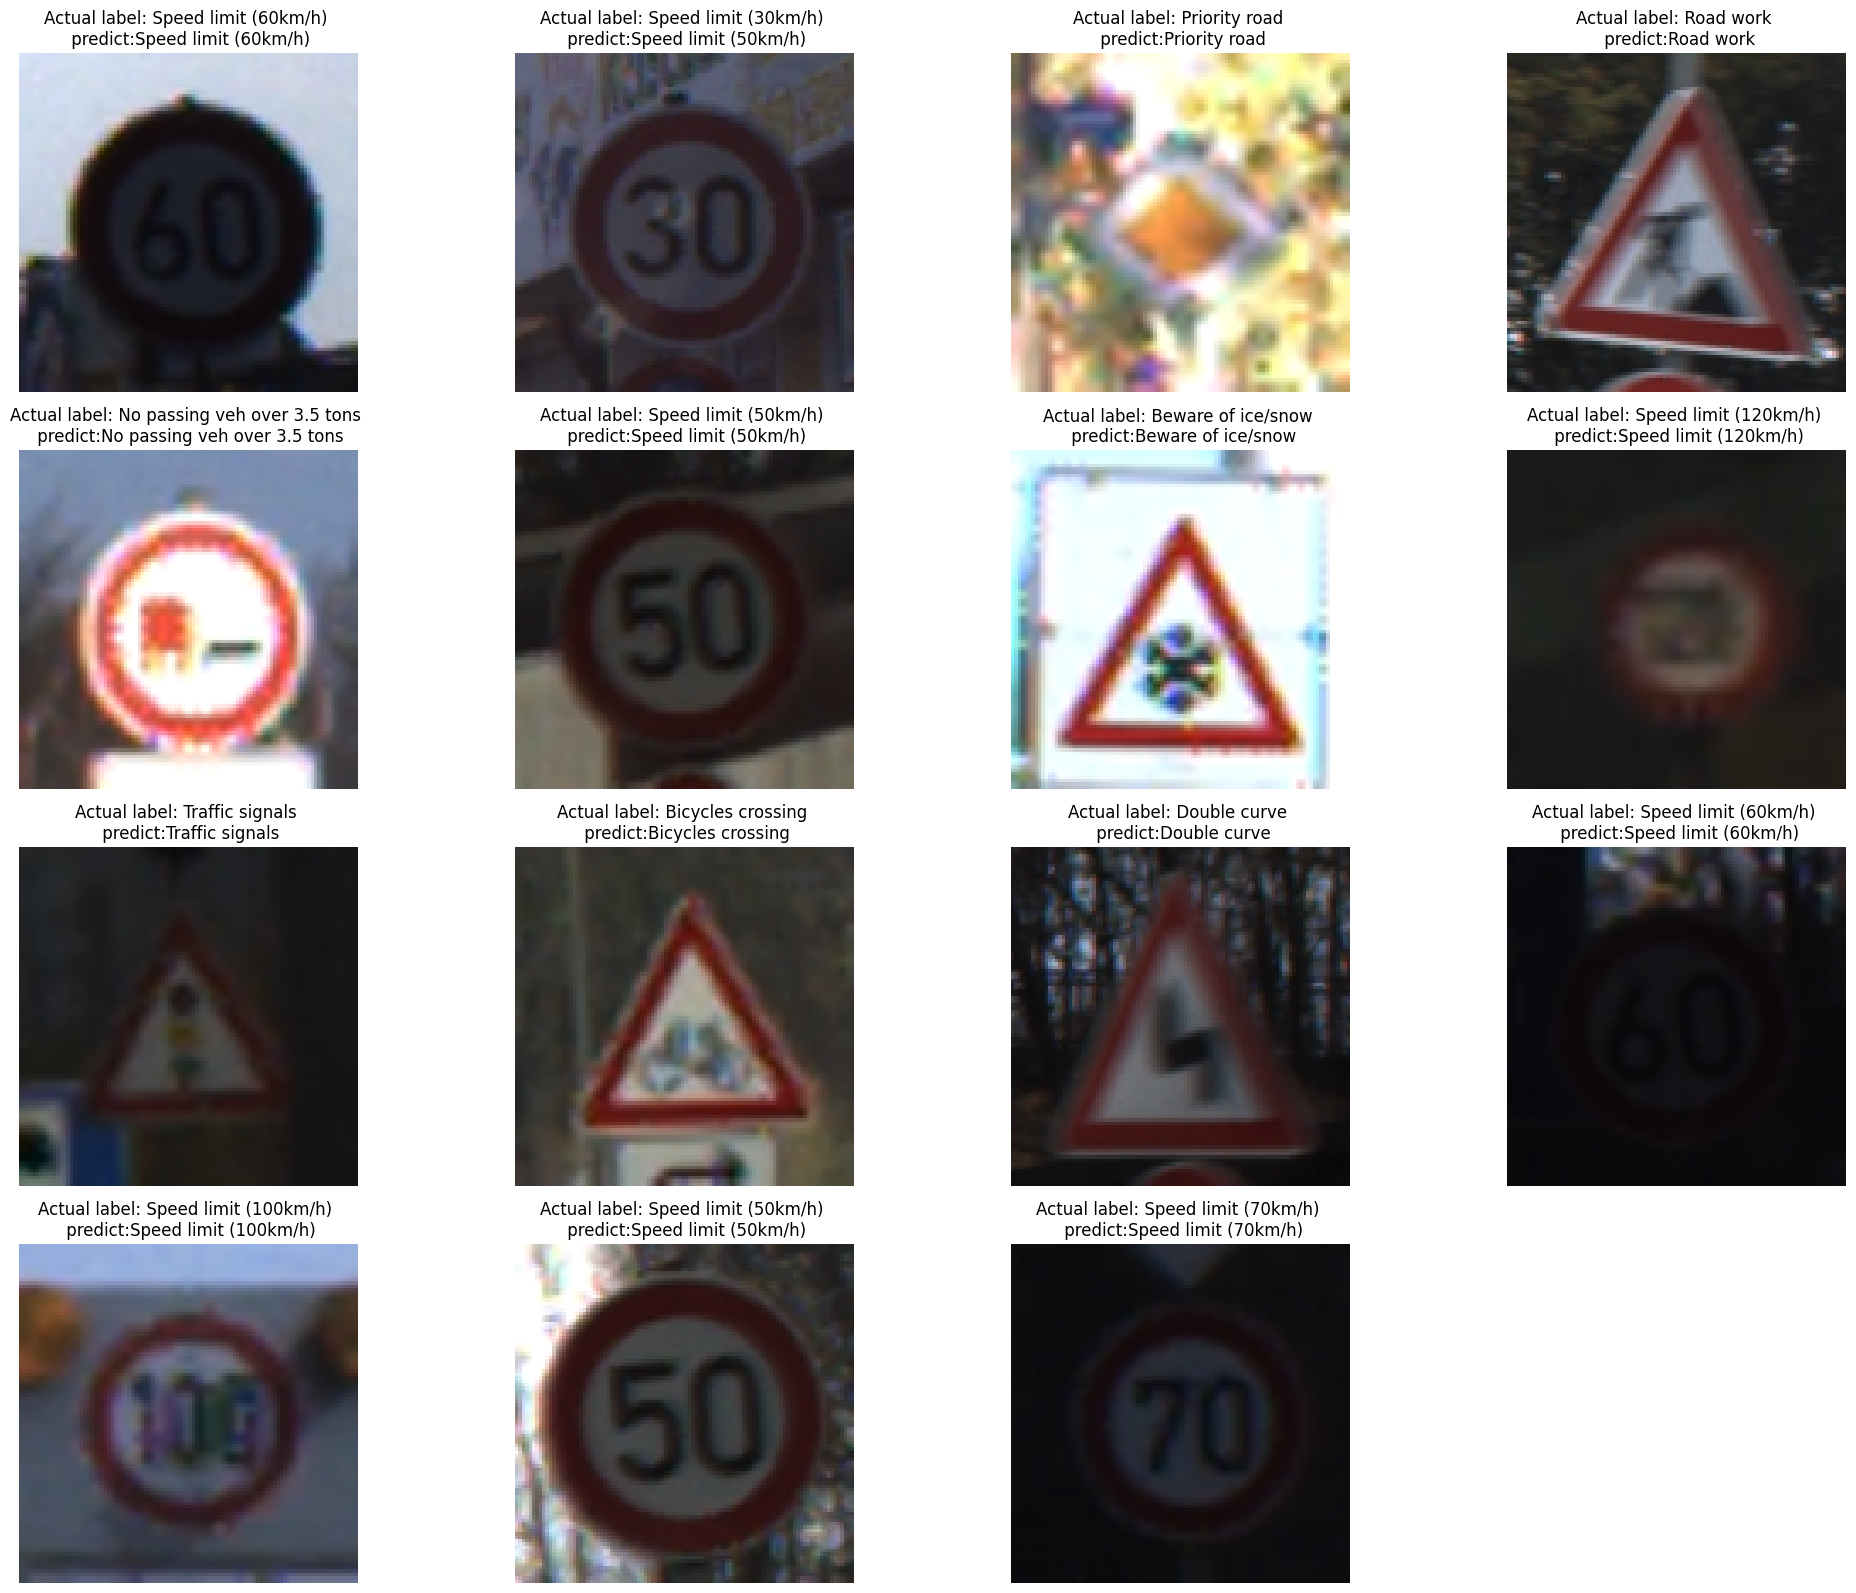

In [17]:
sample=np.random.randint(0,x_test.shape[0],15)
plt.figure(figsize=(20,20))
for e,i in enumerate(sample):
    plt.subplot(5,4,e+1)
    plt.imshow(x_test[i])
    plt.axis('off')
    plt.title(f'Actual label: {classes[Y_test[i]]} \n predict:{classes[prediction[i]]}')
    plt.tight_layout()
plt.show()

In [18]:
model.save('/kaggle/working/my_model.h5')